# Adrien Coutelle IMA205 Project

link to kaggle: https://www.kaggle.com/t/2dddc92296c842f7a88f1082179f3dfa

## Libraries
I use python 3.11.3 with a venv.


In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torchio as tio
import cv2
import csv
from skimage import measure
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, StandardScaler
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

/Users/adriencoutelle/Documents/TELECOM_Paris/2A/IMA/IMA205/Projet/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## First tests to understand the data


torch.Size([1, 216, 256, 10])


NiftiImageIO (0x29fdec250): Train/001/001_ED.nii has unexpected scales in sform

NiftiImageIO (0x29fdec250): Train/001/001_ED.nii has unexpected scales in sform



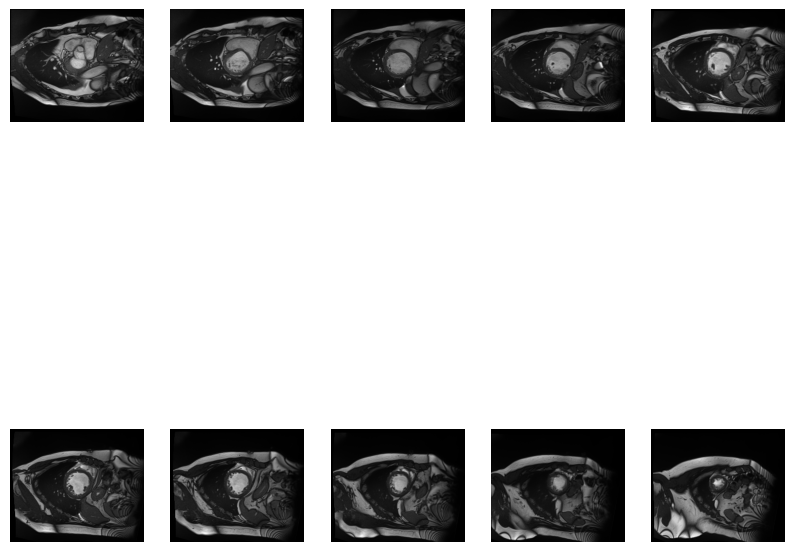

/var/folders/m9/y43c48k57wd1k_m7c5rgtrvm0000gn/T/ipykernel_21044/2753915948.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(labels))
NiftiImageIO (0x29ddf18b0): Train/001/001_ED_seg.nii has unexpected scales in sform

NiftiImageIO (0x29ddf18b0): Train/001/001_ED_seg.nii has unexpected scales in sform



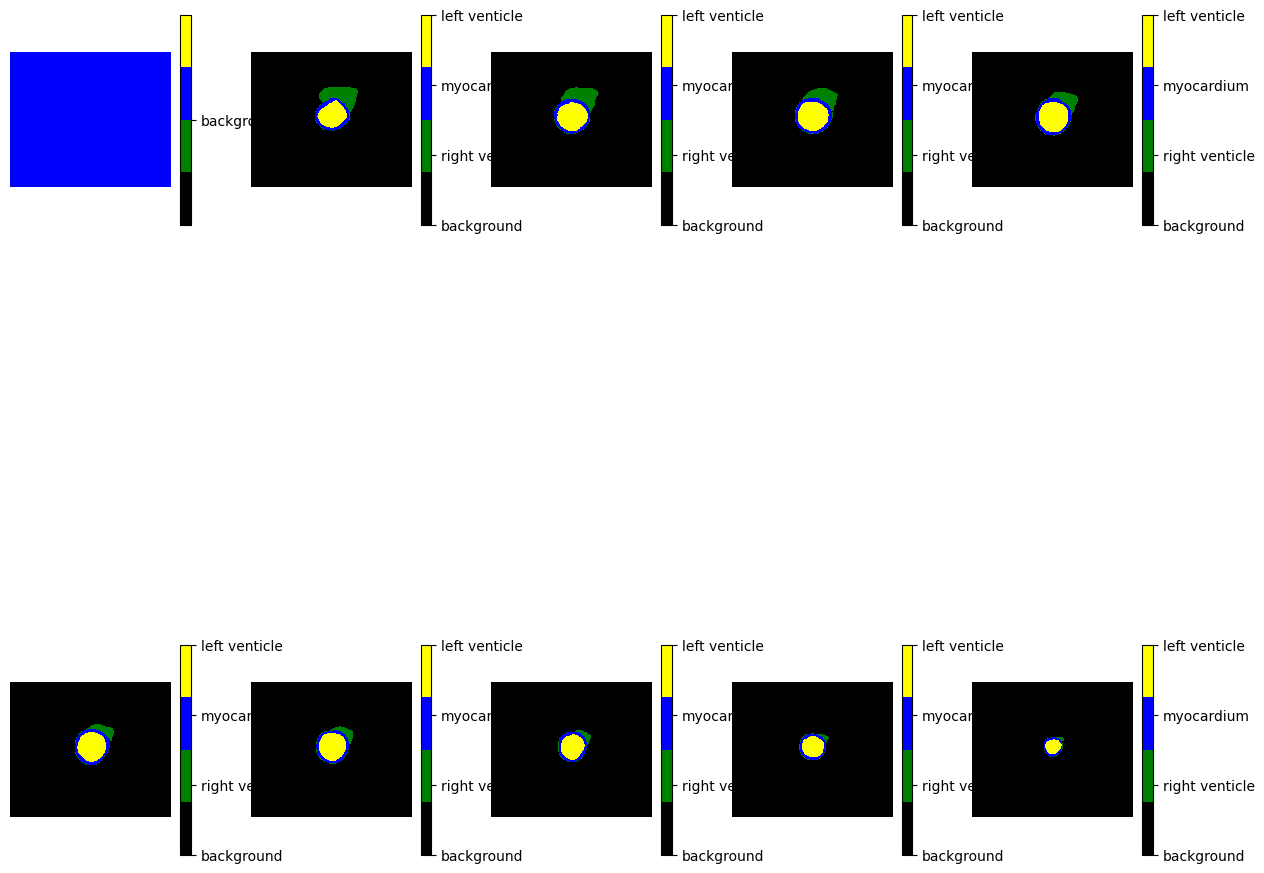

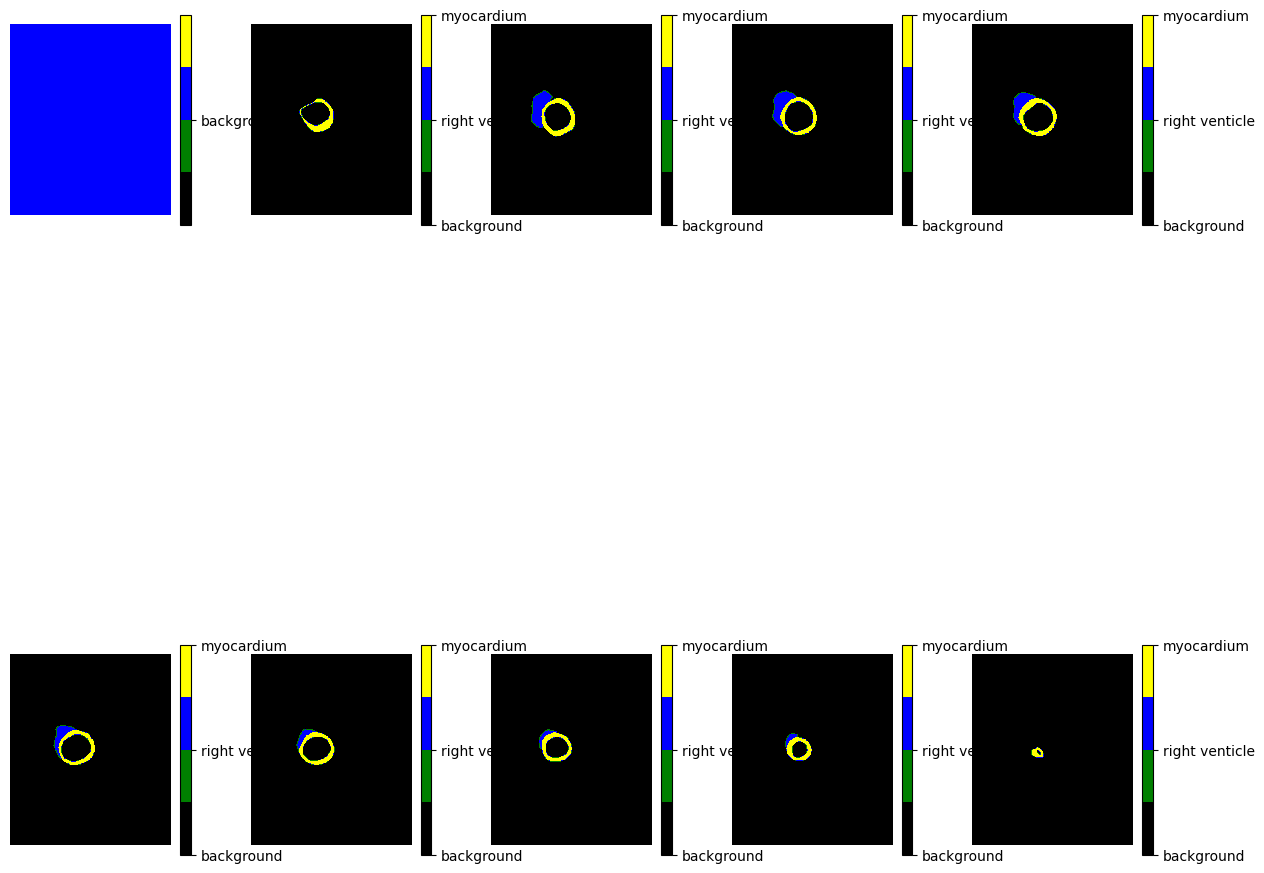

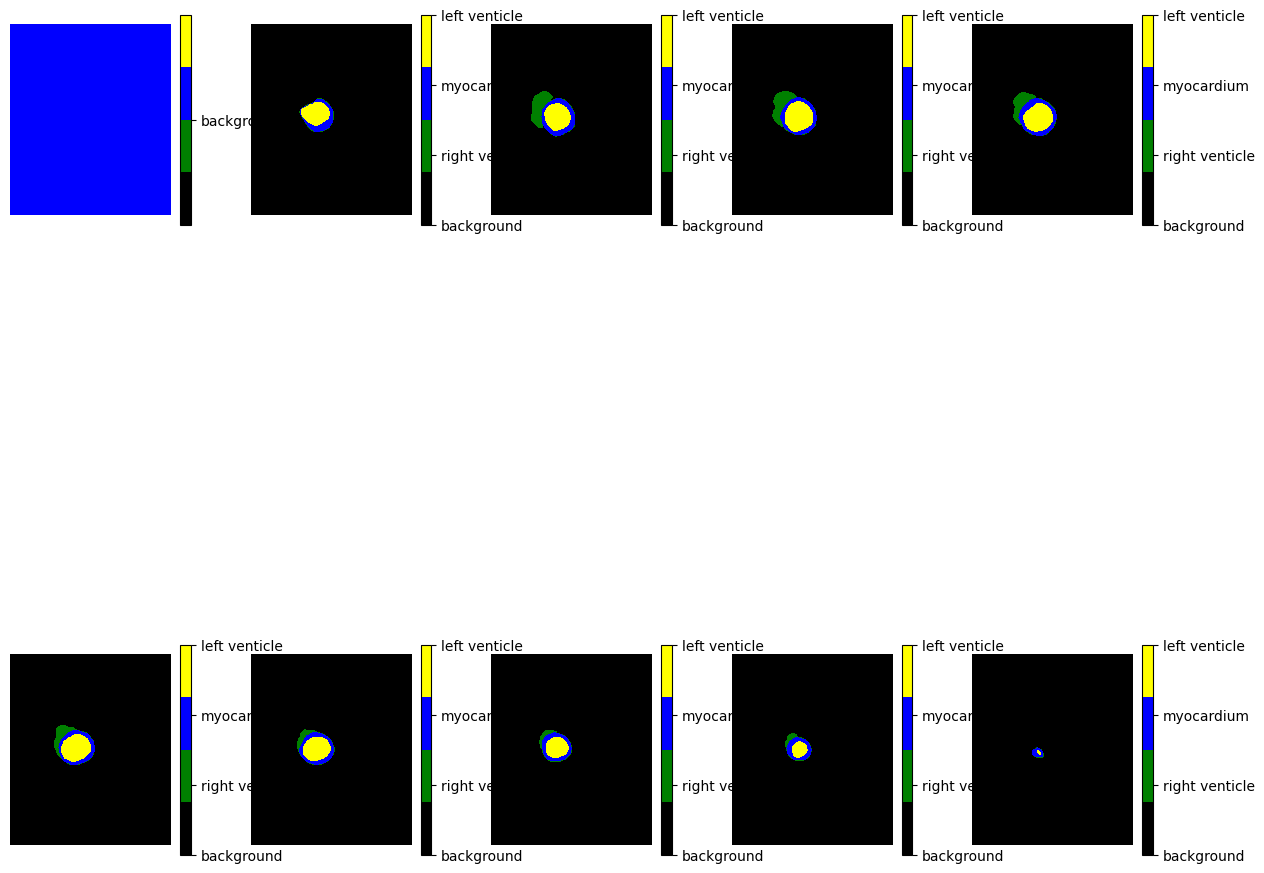

In [2]:
############################################# display images #############################################

def read_nii_image(path):
    return tio.ScalarImage(path)
    
def display_nii_image(path):
    """
    takes the path to the 3D image (what we have in the data) and displays 3 2D images (one for each plane)
    """
    image = tio.ScalarImage(path)
    data = image.data
    print(data.shape)
    plt.figure(figsize=(10,10))
    for i in range(data.shape[-1]):
        plt.subplot(2,5,i+1)
        plt.axis('off')
        plt.imshow(data[0][:,:,i], cmap='gray')
    plt.show()

def tree_digits_number(i):
    if i < 10:
        return '00' + str(i)
    elif i < 100:
        return '0' + str(i)
    else:
        return str(i)
    
############################################# segmentation #############################################
    
def seg_left_ventricle(image):
    # Convert to binary image
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # The internal contour is the left ventricule, and it is the smallest contour
    contour_int = min(contours, key=cv2.contourArea) 
    masque = np.zeros_like(image)
    cv2.drawContours(masque, [contour_int], 0, (3, 3 ,3), -1)
    return masque

def fill_hole(data):
    data_output = np.zeros_like(data.__array__())
    for i in range(1, data.shape[-1]):
        if (data[0][:,:,i].__array__().sum()==0): # if there is no segmentation, we keep the image as it is
            mask = data[0][:,:,i].__array__()
        else:
            mask = seg_left_ventricle(data[0][:,:,i].__array__())
        data_output[0][:,:,i] = mask
    return data_output

def display_seg(path,test=False):
    image = read_nii_image(path)
    labels = ["background", "right venticle", "myocardium", "left venticle"]
    cmap = plt.cm.get_cmap("tab10", len(labels))
    cmap_dict = {l: cmap(i) for i, l in enumerate(labels)}
    data = image.data
    if(test):
        img_ = fill_hole(data) + data.__array__()
    else:
        img_ = data.__array__()
    print()
    plt.figure(figsize=(15,15))
    for i in range(data.shape[-1]):
        #display each pixel value in a different color
        
        plt.subplot(2,5,i+1)
        colors = ['black', 'green', 'blue', 'yellow']
        cmap = ListedColormap(colors)
        plt.axis('off')
        plt.imshow(img_[0][:,:,i], cmap=cmap)
        # add colorbar with labels 'background', 'myocardium', 'blood pool', 'left ventricle'
        plt.colorbar(ticks=[0, 1, 2, 3], shrink=0.4).set_ticklabels(labels)
    
        
    # show the plot
    plt.show()

path_ED  = "./Train/001/001_ED.nii"
path_seg_ED = "./Train/001/001_ED_seg.nii"
path_ES  = "./Test/101/101_ES.nii"
path_seg_ES = "./Test/101/101_ES_seg.nii"

display_nii_image(path_ED)
display_seg(path_seg_ED)
display_seg(path_seg_ES)
display_seg(path_seg_ES,test=True)


## Features extraction

In [3]:
#compute the area of the segmentation
def compute_volume(data):
    vol1, vol2, vol3 = 0.,0.,0.
    for i in range(data.shape[-1]):
        data0123 = data[0][:,:,i].__array__()
        vol1 += np.sum(data0123 == 1)
        vol2 += np.sum(data0123 == 2)
        vol3 += np.sum(data0123 == 3)
    #normalization by the total number of pixels
    vol1 = vol1 / (data.shape[-1] * data.shape[-2] * data.shape[-3])
    vol2 = vol2 / (data.shape[-1] * data.shape[-2] * data.shape[-3])
    vol3 = vol3 / (data.shape[-1] * data.shape[-2] * data.shape[-3])
    return np.array([vol1, vol2, vol3])


    
path_ED  = "./Train/001/001_ED.nii"
vol = compute_volume(read_nii_image(path_seg_ED).data) 
print("volume of the segmentation: ", vol)


volume of the segmentation:  [0.01034975 0.01216725 0.02188947]


NiftiImageIO (0x29fdef780): Train/001/001_ED_seg.nii has unexpected scales in sform

NiftiImageIO (0x29fdef780): Train/001/001_ED_seg.nii has unexpected scales in sform



In [4]:

###################################### volumes and patient charasteristics ######################################

# add volumes
all_features_train = []
all_features_test = []
y_train = []
for i in range(1, 101):
    folder = "./Train/" + tree_digits_number(i)
    folder_seg = folder+"/{}_ED_seg.nii".format(tree_digits_number(i))
    image = tio.ScalarImage(folder_seg)
    vol_ED = compute_volume(image.data)
    folder_seg = folder+"/{}_ES_seg.nii".format(tree_digits_number(i))
    image = tio.ScalarImage(folder_seg)
    vol_ES = compute_volume(image.data)
    all_features_train.append(np.concatenate((vol_ED, vol_ES)))

for i in range(101, 151):
    folder = "./Test/" + tree_digits_number(i)
    folder_seg = folder+"/{}_ED_seg.nii".format(tree_digits_number(i))
    image = read_nii_image(folder_seg)
    data = image.data
    img_ = fill_hole(data) + data.__array__()
    vol_ED = compute_volume(img_)
    folder_seg = folder+"/{}_ES_seg.nii".format(tree_digits_number(i))
    image = read_nii_image(folder_seg)
    data = image.data
    img_ = fill_hole(data) + data.__array__()
    vol_ES = compute_volume(img_)
    all_features_test.append(np.concatenate((vol_ED, vol_ES)))

# add patient charasteristics
with open('metaDataTrain.csv', 'r') as file:
    reader = csv.reader(file)
    for i, row in enumerate(reader):
        if i>0:
            all_features_train[i-1] = np.concatenate((all_features_train[i-1], np.array([row[2], row[3]])))

with open('metaDataTest.csv', 'r') as file:
    reader = csv.reader(file)
    for i, row in enumerate(reader):
        if i>0:
            all_features_test[i-1] = np.concatenate((all_features_test[i-1], np.array([row[1], row[2]])))

# add labels to y_train
with open('metaDataTrain.csv', 'r') as file:
    reader = csv.reader(file)
    for i, row in enumerate(reader):
        if i>0:
            y_train.append(int(row[1]))

####################################### Ejection fraction ######################################

for i in range(100):
    #compute ejection fraction right ventricule
    EDV = float(all_features_train[i][0])
    ESV = float(all_features_train[i][3])
    EF_R = (EDV-ESV)/EDV
    #compute ejection fraction left ventricule
    EDV = float(all_features_train[i][2])
    ESV = float(all_features_train[i][5])
    EF_L = (EDV-ESV)/EDV
    all_features_train[i] = np.concatenate((all_features_train[i],np.array([EF_R,EF_L])))

for i in range(50):
    #compute ejection fraction right ventricule
    EDV = float(all_features_test[i][0])
    ESV = float(all_features_test[i][3])
    EF_R = (EDV-ESV)/EDV
    #compute ejection fraction left ventricule
    EDV = float(all_features_test[i][2])
    ESV = float(all_features_test[i][5])
    EF_L = (EDV-ESV)/EDV
    all_features_test[i] = np.concatenate((all_features_test[i],np.array([EF_R,EF_L])))



####################################### volume ratio ######################################

for i in range(100):
    #compute volume ratio between right and left ventricle at ED (V[RV]/V[LV] ED), 
    V_RV_ED = float(all_features_train[i][0])
    V_LV_ED = float(all_features_train[i][2])
    frac_L = V_RV_ED/V_LV_ED
    # volume ratio between myocardium and left ventricle at ES (V[MYO]/V[LV] ES)
    V_MYO_ES = float(all_features_train[i][4])
    V_LV_ES = float(all_features_train[i][5])
    frac_M = (EDV-ESV)/EDV
    all_features_train[i] = np.concatenate((all_features_train[i],np.array([frac_L,frac_M])))

for i in range(50):
    #compute volume ratio between right and left ventricle at ED (V[RV]/V[LV] ED), 
    V_RV_ED = float(all_features_test[i][0])
    V_LV_ED = float(all_features_test[i][2])
    frac_L = V_RV_ED/V_LV_ED
    # volume ratio between myocardium and left ventricle at ES (V[MYO]/V[LV] ES)
    V_MYO_ES = float(all_features_test[i][4])
    V_LV_ES = float(all_features_test[i][5])
    frac_M = (EDV-ESV)/EDV
    all_features_test[i] = np.concatenate((all_features_test[i],np.array([frac_L,frac_M])))

####################################### thickness of the myocardium ######################################

for i in range(100):
    #approximation : myocardium and left ventricle are spheres
    V_ext = float(all_features_train[i][1]) + float(all_features_train[i][2])
    V_int = float(all_features_train[i][2])
    R_ext = (3*V_ext/(4*np.pi))**(1/3)
    R_int = (3*V_int/(4*np.pi))**(1/3)
    thickness_ED = R_ext - R_int
    #approximation : myocardium and left ventricle are spheres
    V_ext = float(all_features_train[i][4]) + float(all_features_train[i][5])
    V_int = float(all_features_train[i][5])
    R_ext = (3*V_ext/(4*np.pi))**(1/3)
    R_int = (3*V_int/(4*np.pi))**(1/3)
    thickness_ES = R_ext - R_int
    all_features_train[i] = np.concatenate((all_features_train[i],np.array([thickness_ED,thickness_ES])))

for i in range(50):
    #approximation : myocardium and left ventricle are spheres
    V_ext = float(all_features_test[i][1]) + float(all_features_test[i][2])
    V_int = float(all_features_test[i][2])
    R_ext = (3*V_ext/(4*np.pi))**(1/3)
    R_int = (3*V_int/(4*np.pi))**(1/3)
    thickness_ED = R_ext - R_int
    #approximation : myocardium and left ventricle are spheres
    V_ext = float(all_features_test[i][4]) + float(all_features_test[i][5])
    V_int = float(all_features_test[i][5])
    R_ext = (3*V_ext/(4*np.pi))**(1/3)
    R_int = (3*V_int/(4*np.pi))**(1/3)
    thickness_ES = R_ext - R_int
    all_features_test[i] = np.concatenate((all_features_test[i],np.array([thickness_ED,thickness_ES])))

print(all_features_train[0])


NiftiImageIO (0x2a49159d0): Train/001/001_ED_seg.nii has unexpected scales in sform

NiftiImageIO (0x2a49159d0): Train/001/001_ED_seg.nii has unexpected scales in sform

NiftiImageIO (0x2a4504a50): Train/001/001_ES_seg.nii has unexpected scales in sform

NiftiImageIO (0x2a4504a50): Train/001/001_ES_seg.nii has unexpected scales in sform

NiftiImageIO (0x29e9e3f30): Train/002/002_ED_seg.nii has unexpected scales in sform

NiftiImageIO (0x29e9e3f30): Train/002/002_ED_seg.nii has unexpected scales in sform

NiftiImageIO (0x29fdf0e40): Train/002/002_ES_seg.nii has unexpected scales in sform

NiftiImageIO (0x29fdf0e40): Train/002/002_ES_seg.nii has unexpected scales in sform

NiftiImageIO (0x2a4917000): Train/003/003_ED_seg.nii has unexpected scales in sform

NiftiImageIO (0x2a4917000): Train/003/003_ED_seg.nii has unexpected scales in sform

NiftiImageIO (0x29e9e3160): Train/003/003_ES_seg.nii has unexpected scales in sform

NiftiImageIO (0x29e9e3160): Train/003/003_ES_seg.nii has unexpect

['0.010349754050925926' '0.01216724537037037' '0.021889467592592592'
 '0.004410807291666667' '0.014449508101851851' '0.01671187789351852'
 '184.0' '95.0' '0.5738249170015726' '0.23653337739590213'
 '0.4728189028420357' '0.2411214953271028' '0.027548107398212618'
 '0.03660999374749438']


## Select features

In [5]:
def select_features(
    right_ventricle_cavity_ED: bool = True,
    myocardium_ED: bool = True,
    left_ventricle_cavity_ED: bool = True,
    right_ventricle_cavity_ES: bool = True,
    myocardium_ES: bool = True,
    left_ventricle_cavity_ES: bool = True,
    height: bool = True,
    weight: bool = True,
    EF_R: bool = True,
    EF_L: bool = True
    , ratio_left_right_vent_ED=True
    , ratio_myo_left_ES=True
    , thickness_ED=True
    , thickness_ES=True):
    xtrain = []
    xtest = []
    for i in range(len(all_features_train)):
        xtrain.append([])
        if right_ventricle_cavity_ED:
            xtrain[i].append(all_features_train[i][0])
        if myocardium_ED:
            xtrain[i].append(all_features_train[i][1])
        if left_ventricle_cavity_ED:
            xtrain[i].append(all_features_train[i][2])
        if right_ventricle_cavity_ES:
            xtrain[i].append(all_features_train[i][3])
        if myocardium_ES:
            xtrain[i].append(all_features_train[i][4])
        if left_ventricle_cavity_ES:
            xtrain[i].append(all_features_train[i][5])
        if height:
            xtrain[i].append(all_features_train[i][6])
        if weight:
            xtrain[i].append(all_features_train[i][7])
        if EF_R:
            xtrain[i].append(all_features_train[i][8])
        if EF_L:
            xtrain[i].append(all_features_train[i][9])
        if ratio_left_right_vent_ED:
            xtrain[i].append(all_features_train[i][10])
        if ratio_myo_left_ES:
            xtrain[i].append(all_features_train[i][11])
        if thickness_ED:
            xtrain[i].append(all_features_train[i][12])
        if thickness_ES:
            xtrain[i].append(all_features_train[i][13])

    for i in range(len(all_features_test)):
        xtest.append([])
        if right_ventricle_cavity_ED:
            xtest[i].append(all_features_test[i][0])
        if myocardium_ED:
            xtest[i].append(all_features_test[i][1])
        if left_ventricle_cavity_ED:
            xtest[i].append(all_features_test[i][2])
        if right_ventricle_cavity_ES:
            xtest[i].append(all_features_test[i][3])
        if myocardium_ES:
            xtest[i].append(all_features_test[i][4])
        if left_ventricle_cavity_ES:
            xtest[i].append(all_features_test[i][5])
        if height:
            xtest[i].append(all_features_test[i][6])
        if weight:
            xtest[i].append(all_features_test[i][7])
        if EF_R:
            xtest[i].append(all_features_test[i][8])
        if EF_L:
            xtest[i].append(all_features_test[i][9])
        if ratio_left_right_vent_ED:
            xtest[i].append(all_features_test[i][10])
        if ratio_myo_left_ES:
            xtest[i].append(all_features_test[i][11])
        if thickness_ED:
            xtest[i].append(all_features_test[i][12])
        if thickness_ES:
            xtest[i].append(all_features_test[i][13])

    return np.array(xtrain, dtype=float) , np.array(xtest, dtype=float)
    




## Model

In [6]:

X_train,X_test = select_features()

RF = RandomForestClassifier(random_state=1, n_estimators=80, min_samples_leaf=2, max_features='sqrt')
#sequential feature selection 
sfs = SequentialFeatureSelector(RF, n_features_to_select=10)
seq = sfs.fit(X_train, y_train)
print(seq.get_support())
X_train = sfs.transform(X_train)
X_test = sfs.transform(X_test)

RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)

# create a csv with y_pred
with open('y_pred.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['Id', 'Category'])
    for i in range(len(y_pred)):
        writer.writerow([i+101, y_pred[i]])

[ True False False  True  True  True  True  True  True  True  True  True
 False False]
